# Modelagem - Quality Prediction in a Mining Process

* Ciencia de Dados - IHM Stefanini
* Autor: Alisson Santiago Amaral, Cientista de dados.

> Objetivo:

* O objetivo principal é analisar e modelar os dados de medições de qualidade no processo de flotação do minério de ferro, para prever a quantidade de sílica (impureza) no concentrado de minério.

* Avaliar e escolher o melhor modelo de regressão, testando o dataset com e sem feature selection.

> Motivação:
* Como essa impureza é medida a cada hora, se pudermos prever quanta sílica (impureza) há no concentrado de minério, podemos ajudar os engenheiros, dando-lhes informações para que tomem decisões antecipadas. Assim, eles poderão antecipar ações corretivas (diminuir impurezas, se for o caso) e também ajudar o meio ambiente (diminuindo a quantidade de minério que vai para o rejeito à medida que você reduz a sílica no concentrado de minério).

* Ao final do projeto poderemos responder alguns questionamentos:
    - É possível prever a % de sílica concentrada a cada minuto?
    - Quantas etapas (horas) à frente podemos prever % de sílica concentrada?
    - É possível prever % de sílica em concentrado sem a coluna de concentrado de ferro (como eles estão altamente correlacionados)?

> Fonte:

* https://www.kaggle.com/datasets/edumagalhaes/quality-prediction-in-a-mining-process

## Sumário:

0. Introdução

        0.1 Imports

1. Feature selection

        1.1 Correlação
        1.2 RFE (Recursive Feature Elimination)
        1.3 Backward Elimination
        1.4 Datasets

2. Escolha do Modelo

        2.1 Data_1
            2.1.1 Divisão do dataset(treino e teste)
            2.1.2 Gridsearch
            2.1.3 Model tuning: Bayesian Optimization
                2.1.3.1 Random Forest
                2.1.3.2 XGboost
            2.1.4 Resultados

        2.2 Data_2
            2.2.1 Divisão do dataset(treino e teste)
            2.2.2 Gridsearch
            2.2.3 Model tuning: Bayesian Optimization
                2.2.3.1 Random Forest
                2.2.3.2 XGboost

        2.3 Data_3
            2.3.1 Divisão do dataset(treino e teste)
            2.3.2 Gridsearch
            2.3.3 Model tuning: Bayesian Optimization
                2.3.3.1 Random Forest
                2.3.3.2 XGboost
            2.3.4 Resultados

3. Resultado final

        3.1 Conclusão

4. Referências

# 0. Introdução

## 0.1 Imports

In [1]:
#Importando as bibliotecas
import pandas as pd
import numpy as np
from scipy import stats


#Data Viz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from skopt.plots import plot_convergence

# Feature selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedKFold, StratifiedKFold

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from skopt import gp_minimize

# Models
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso

# ARIMA
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA

# Métrics
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')


# Config
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('./Dataset/df_hour.csv', decimal=".",sep=",", 
                    parse_dates=["date"], infer_datetime_format=True, index_col='date')

df

,per_iron_feed,per_silica_feed,starch_flow,amina_flow,ore_pulp_flow,ore_pulp_ph,ore_pulp_density,column_01_air_flow,column_02_air_flow,column_03_air_flow,column_04_air_flow,column_05_air_flow,column_06_air_flow,column_07_air_flow,column_01_level,column_02_level,column_03_level,column_04_level,column_05_level,column_06_level,column_07_level,per_iron_concentrate,per_silica_concentrate,column_06_07_level,column_01_02_03_level,column_04_05_level,column_01_02_03_air_flow,column_04_05_air_flow,column_06_07_air_flow
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-29 19:00:00,59.54,9.56,1913.01,495.24,399.95,9.56,1.67,199.87,195.57,200.05,295.10,306.40,250.01,250.04,855.86,818.48,882.99,559.46,556.97,518.05,523.23,66.28,1.69,520.640,852.443333,558.215,198.496667,300.750,250.025
2017-03-29 20:00:00,59.54,9.56,2033.82,500.49,400.51,9.28,1.68,199.90,195.38,199.86,295.10,306.40,250.07,250.02,855.70,816.52,883.01,589.51,601.72,549.20,548.97,64.13,1.81,549.085,851.743333,595.615,198.380000,300.750,250.045
2017-03-29 21:00:00,59.54,9.56,2213.60,530.64,400.36,9.59,1.72,199.88,195.37,199.92,295.10,306.40,250.02,250.21,855.54,814.56,884.39,589.16,603.13,549.18,552.95,65.88,1.71,551.065,851.496667,596.145,198.390000,300.750,250.115
2017-03-29 22:00:00,59.54,9.56,2004.49,531.89,399.08,9.64,1.73,199.89,196.65,199.91,295.10,306.40,250.03,249.89,855.37,816.51,877.33,580.11,596.83,549.98,544.49,64.69,2.92,547.235,849.736667,588.470,198.816667,300.750,249.960
2017-03-29 23:00:00,59.54,9.56,1813.14,530.98,400.06,9.59,1.72,199.90,195.33,199.97,295.10,306.40,249.99,250.09,855.21,819.41,882.85,581.98,599.23,551.25,548.53,65.85,2.00,549.890,852.490000,590.605,198.400000,300.750,250.040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 19:00:00,49.75,23.20,3327.05,497.21,380.85,9.18,1.66,301.57,300.17,299.90,299.95,299.92,335.66,298.74,397.78,498.75,403.86,398.93,502.97,399.47,400.56,65.05,1.65,400.015,433.463333,450.950,300.546667,299.935,317.200
2017-09-09 20:00:00,49.75,23.20,4225.80,508.96,381.11,9.39,1.69,300.05,299.97,299.91,299.96,299.96,348.17,303.60,399.93,499.65,399.21,399.97,501.62,398.91,400.49,64.83,1.71,399.700,432.930000,450.795,299.976667,299.960,325.885
2017-09-09 21:00:00,49.75,23.20,2808.21,517.75,381.06,9.77,1.74,299.81,299.80,299.97,299.86,299.93,349.42,309.88,399.96,500.48,471.83,399.93,500.22,401.90,400.56,64.29,1.80,401.230,457.423333,450.075,299.860000,299.895,329.650


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      3941 non-null   datetime64[ns]
 1   per_iron_feed             3941 non-null   float64       
 2   per_silica_feed           3941 non-null   float64       
 3   starch_flow               3941 non-null   float64       
 4   amina_flow                3941 non-null   float64       
 5   ore_pulp_flow             3941 non-null   float64       
 6   ore_pulp_ph               3941 non-null   float64       
 7   ore_pulp_density          3941 non-null   float64       
 8   column_01_air_flow        3941 non-null   float64       
 9   column_02_air_flow        3941 non-null   float64       
 10  column_03_air_flow        3941 non-null   float64       
 11  column_04_air_flow        3941 non-null   float64       
 12  column_05_air_flow  

# 1. Feature selection

## 1.1 Correlação

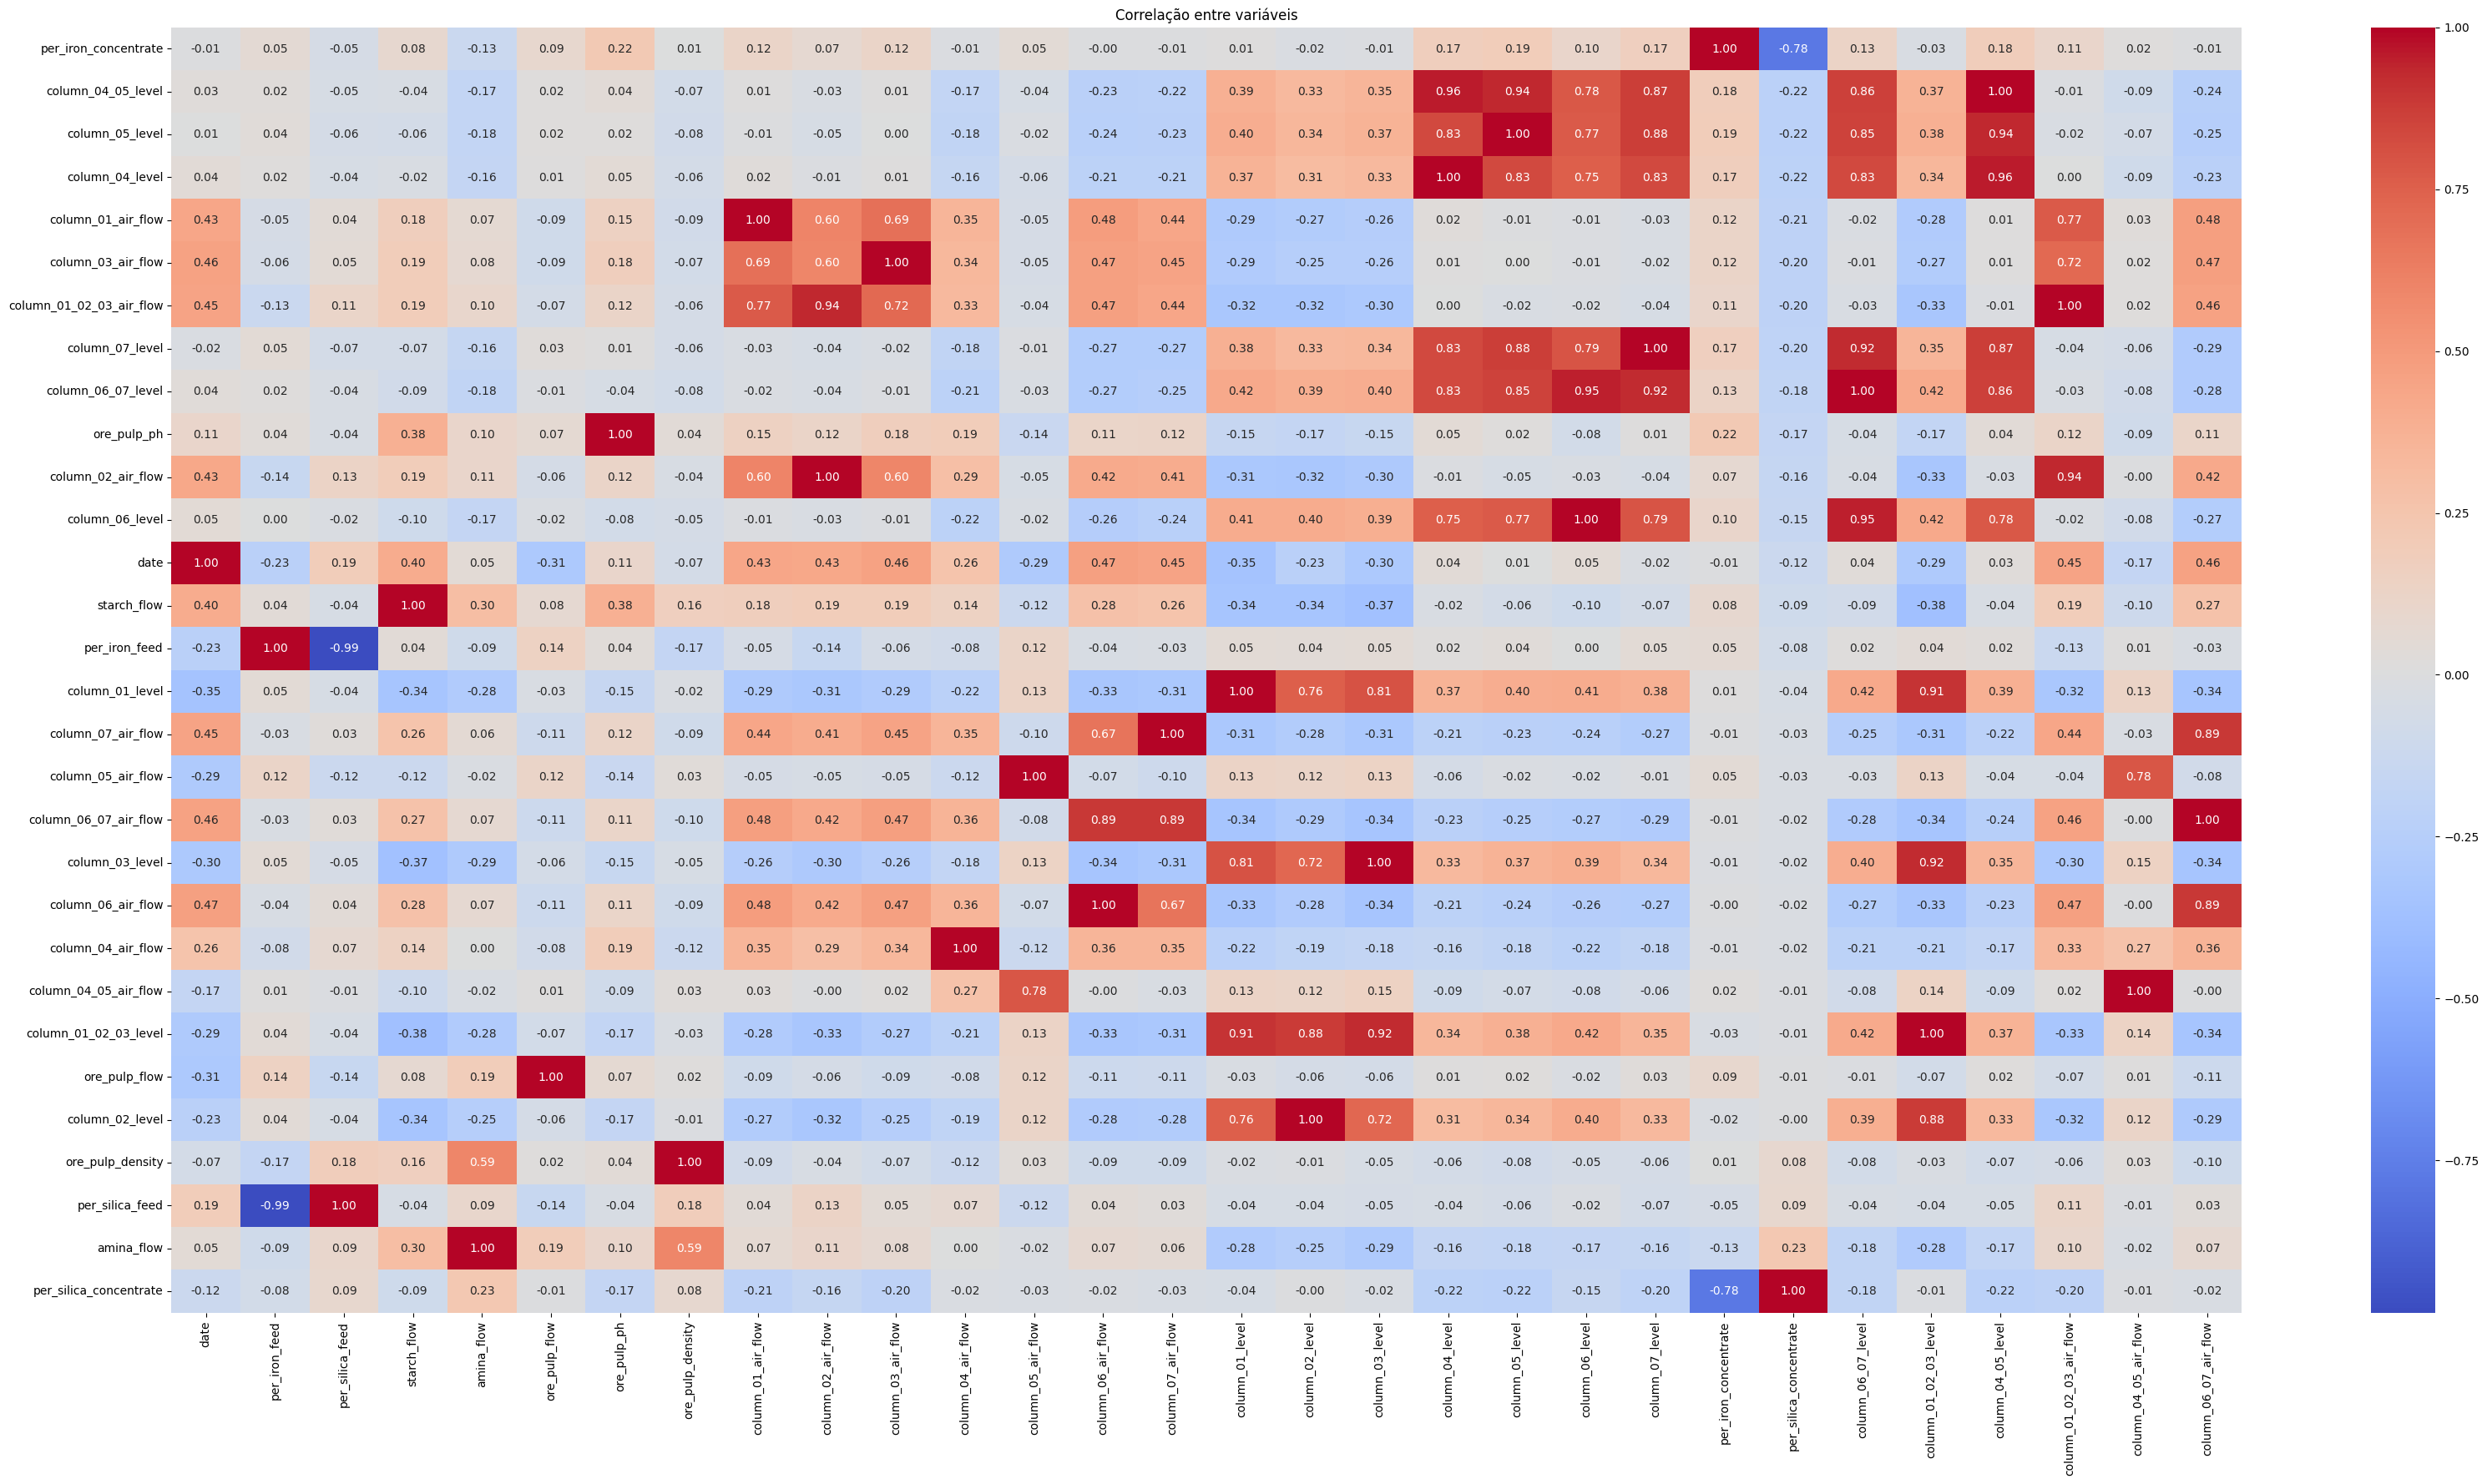

In [4]:
plt.figure(figsize=(40, 20))

sns.heatmap(df.corr(method='spearman', numeric_only=False).sort_values('per_silica_concentrate'),
            annot = True,
            fmt = '.2f',
            cmap='coolwarm')
plt.title('Correlação entre variáveis')
plt.show()

In [7]:
#ordenar correlações do target, pelo seu valor absoluto
df.corr(method='spearman', numeric_only=False)['per_silica_concentrate'].abs().sort_values(ascending=False)

per_silica_concentrate      1.000000
per_iron_concentrate        0.778010
amina_flow                  0.230104
column_04_05_level          0.222418
column_05_level             0.219350
column_04_level             0.215601
column_01_air_flow          0.207114
column_03_air_flow          0.202235
column_01_02_03_air_flow    0.202012
column_07_level             0.196168
column_06_07_level          0.179090
ore_pulp_ph                 0.166523
column_02_air_flow          0.161977
column_06_level             0.152046
date                        0.121380
starch_flow                 0.093556
per_silica_feed             0.087248
ore_pulp_density            0.081682
per_iron_feed               0.076203
column_01_level             0.039553
column_07_air_flow          0.033653
column_05_air_flow          0.025208
column_06_07_air_flow       0.024523
column_03_level             0.024337
column_06_air_flow          0.022799
column_04_air_flow          0.020174
column_04_05_air_flow       0.012381
c

> Observações:

* Variáveis com menor correlação de Spearman: column_02_level, ore_pulp_flow

## 1.2 RFE (Recursive Feature Elimination)

O RFE é um algoritmo que seleciona um subconjunto ótimo de variáveis de um conjunto inicial, recursivamente eliminando as variáveis menos importantes. O processo começa com um modelo treinado em todas as variáveis e, em seguida, as variáveis menos importantes são eliminadas uma a uma, até que o número de variáveis desejado seja alcançado.

O RFE utiliza um modelo de machine learning para avaliar a importância relativa de cada variável. As variáveis com menor importância são então eliminadas, e o processo é repetido até que apenas as variáveis mais importantes permaneçam. A seleção é baseada em um critério pré-definido, como a precisão do modelo, o coeficiente de determinação (R²) ou a pontuação de validação cruzada.

Iremos utilizar essa técnica primeiramente para descobrir qual o número ideal de variáveis para termos boas previsões.

In [8]:
X = df.drop(['date','per_silica_concentrate'], axis=1)
y = df['per_silica_concentrate']


X_f = X
y_f = y

## Modelo rf
modelo = XGBRegressor(eta = 0.01, n_estimators=300, max_depth= 15)

# Número de Features Previsoras
lista=np.arange(1,22)
# Melhor score iniciando em 0
melhor_score=0
# Variável para armazenar o número ótimo de features
nf=0
# Lista vazia dos scores
lista_score =[]
# Loop
for i in range(len(lista)):
    ## Divisão treino e teste
    X_treino, X_teste, Y_treino, Y_teste = train_test_split(X_f, y_f, train_size = 0.8, random_state = 12)
    ## RF
    modelo = modelo
    ## RFE
    rfe = RFE(modelo,n_features_to_select=lista[i])
    ## Fit transform no treino 
    X_treino_rfe = rfe.fit_transform(X_treino,Y_treino)
    X_teste_rfe = rfe.transform(X_teste)
    ## Treinando com X_treino_rfe e Y_treino
    modelo.fit(X_treino_rfe,Y_treino)
    ## Score do treinamento
    score = modelo.score(X_teste_rfe,Y_teste)
    ## Armazenando resultados na lista vazia
    lista_score.append(score)
    # Observando o melhor score dentre todos e nº ideal de features
    if(score > melhor_score):
        melhor_score = score
        nf = lista[i]
print("Numero ideal de features: %d" %nf)
print("Score com %d features: %f" % (nf, melhor_score))

Numero ideal de features: 19
Score com 19 features: 0.731167


In [9]:
## Extraindo colunas dos Previsores
colunas = list(X_f.columns)
## RF
modelo = XGBRegressor(eta = 0.01, n_estimators=300, max_depth= 15)
## RFE com número ideal de 3 features
rfe = RFE(modelo, n_features_to_select=nf)             
## fit_transform para os Previsores
Previsores_rfe = rfe.fit_transform(X_f,y_f)  
## Treinando
modelo.fit(Previsores_rfe,y_f)         
## Pegando as features que foram selecionadas (.support)
temp = pd.Series(rfe.support_,index=colunas)
## Observando as melhores (.index)
features_selecionadas_rfe = temp[temp==True].index
print(features_selecionadas_rfe)

Index(['per_silica_feed', 'amina_flow', 'ore_pulp_flow', 'column_01_air_flow',
       'column_05_air_flow', 'column_01_level', 'column_02_level',
       'column_03_level', 'column_04_level', 'column_05_level',
       'column_06_level', 'column_07_level', 'per_iron_concentrate',
       'column_06_07_level', 'column_01_02_03_level', 'column_04_05_level',
       'column_01_02_03_air_flow', 'column_04_05_air_flow',
       'column_06_07_air_flow'],
      dtype='object')


## 1.3 Backward elimination

In [21]:
X = df.drop(['date','per_silica_concentrate', 'per_iron_concentrate', 'column_07_air_flow', 'column_02_level', 'column_03_level'
             , 'column_04_level', 'column_01_level', 'per_iron_feed', 'column_02_air_flow', 'column_07_level', 'column_06_level', 
             'column_05_air_flow', 'column_06_air_flow', 'column_06_07_level', 'column_01_02_03_level',
             'column_01_02_03_level', 'column_04_05_level', 'column_01_02_03_air_flow'], axis=1)


y = df['per_silica_concentrate']

X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, y, train_size = 0.8, random_state = 12)

X_f = X
y_f = y

In [22]:
regressor_OLS = sm.OLS(endog = Y_treino, exog = X_treino).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     per_silica_concentrate   R-squared (uncentered):                   0.850
Model:                                OLS   Adj. R-squared (uncentered):              0.849
Method:                     Least Squares   F-statistic:                              1477.
Date:                    Tue, 28 Mar 2023   Prob (F-statistic):                        0.00
Time:                            04:15:36   Log-Likelihood:                         -4489.2
No. Observations:                    3152   AIC:                                      9002.
Df Residuals:                        3140   BIC:                                      9075.
Df Model:                              12                                                  
Covariance Type:                nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
per_silica_feed           0.0085      0.003      3.161      0.002       0.003       0.014
starch_flow              -0.0001    2.3e-05     -4.583      0.000      -0.000   -6.03e-05
amina_flow                0.0049      0.000     15.142      0.000       0.004       0.006
ore_pulp_flow            -0.0059      0.002     -2.473      0.013      -0.011      -0.001
ore_pulp_ph              -0.3354      0.053     -6.383      0.000      -0.438      -0.232
ore_pulp_density         -3.1633      0.396     -7.993      0.000      -3.939      -2.387
column_01_air_flow       -0.0071      0.002     -3.388      0.001      -0.011      -0.003
column_03_air_flow       -0.0070      0.002     -3.169      0.002      -0.011      -0.003
column_04_air_flow        0.0721      0.010      7.485      0.000       0.053       0.091
column_05_level          -0.0022      0.000     -8.322      0.000      -0.003      -0.002
column_04_05_air_flow    -0.0211      0.010     -2.058      0.040      -0.041      -0.001
column_06_07_air_flow     0.0021      0.001      2.111      0.035       0.000       0.004
==============================================================================
Omnibus:                      279.136   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              355.694
Skew:                           0.810   Prob(JB):                     5.78e-78
Kurtosis:                       3.287   Cond. No.                     6.96e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

> Observações:

* Analisando as 3 técnicas de feature selection (Spearmam, RFE e backward elimination):

    - As variáveis selecionadas:
    - Variáveis de entrada, os reagentes, e as medições de qualidade;
    - Air flow e levels 01,03,04,06


> Importante:

* Iremos dividir o Dataset em 2:
    - Data_1: Dataset com todas as variáveis, exceto 'per_iron_concentrate' e as médias de air flow e level.
    
    - Data_2: 'per_silica_feed', 'starch_flow', 'amina_flow', 'ore_pulp_flow', 'ore_pulp_ph', 'ore_pulp_density',
        'column_01_air_flow',  'column_03_air_flow', 'column_04_air_flow',  'column_06_air_flow',
        'column_01_level', 'column_03_level', 'column_04_level', 'column_06_level'

    - Data_3: 'per_iron_feed', 'per_silica_feed', 'per_iron_feed' 'starch_flow', 'amina_flow', 'ore_pulp_flow', 'ore_pulp_ph', 'ore_pulp_density', 'column_01_02_03_air_flow', 'column_04_05_air_flow', 'column_06_07_air_flow', 
                    'column_01_02_03_level', 'column_04_05_level', 'column_06_07_level'

## 1.4 Dataset

In [3]:
df.columns

Index(['per_iron_feed', 'per_silica_feed', 'starch_flow', 'amina_flow',
       'ore_pulp_flow', 'ore_pulp_ph', 'ore_pulp_density',
       'column_01_air_flow', 'column_02_air_flow', 'column_03_air_flow',
       'column_04_air_flow', 'column_05_air_flow', 'column_06_air_flow',
       'column_07_air_flow', 'column_01_level', 'column_02_level',
       'column_03_level', 'column_04_level', 'column_05_level',
       'column_06_level', 'column_07_level', 'per_iron_concentrate',
       'per_silica_concentrate', 'column_06_07_level', 'column_01_02_03_level',
       'column_04_05_level', 'column_01_02_03_air_flow',
       'column_04_05_air_flow', 'column_06_07_air_flow'],
      dtype='object')

In [3]:
Data_1 = df.drop(['per_iron_concentrate', 'column_01_02_03_air_flow', 'column_04_05_air_flow', 'column_06_07_air_flow', 
                    'column_01_02_03_level', 'column_04_05_level', 'column_06_07_level'], axis=1)

Data_2 = df.loc[:,['per_silica_feed','per_iron_feed' ,'starch_flow', 'amina_flow', 'ore_pulp_flow', 'ore_pulp_ph', 'ore_pulp_density',
        'column_01_air_flow',  'column_03_air_flow', 'column_04_air_flow',  'column_06_air_flow',
        'column_01_level', 'column_03_level', 'column_04_level', 'column_06_level','per_silica_concentrate']]

Data_3 = df.loc[:, ['per_iron_feed', 'per_silica_feed', 'starch_flow', 'amina_flow', 
                    'ore_pulp_flow', 'ore_pulp_ph', 'ore_pulp_density',
                    'column_01_02_03_air_flow', 'column_04_05_air_flow', 'column_06_07_air_flow', 
                    'column_01_02_03_level', 'column_04_05_level', 'column_06_07_level', 'per_silica_concentrate']]


Data_1 = Data_1.iloc[:-120,:]
Valid_1 = Data_1.iloc[-120:,:]

Data_2 = Data_2.iloc[:-120,:]
Valid_2 = Data_2.iloc[-120:,:]

Data_3 = Data_3.iloc[:-120,:]
Valid_3 = Data_3.iloc[-120:,:]

In [148]:
print(Data_1.shape)
print(Valid_1.shape)
Data_1.head(2)

(3821, 22)
(120, 22)


,per_iron_feed,per_silica_feed,starch_flow,amina_flow,ore_pulp_flow,ore_pulp_ph,ore_pulp_density,column_01_air_flow,column_02_air_flow,column_03_air_flow,column_04_air_flow,column_05_air_flow,column_06_air_flow,column_07_air_flow,column_01_level,column_02_level,column_03_level,column_04_level,column_05_level,column_06_level,column_07_level,per_silica_concentrate
date,,,,,,,,,,,,,,,,,,,,,,
2017-03-29 19:00:00,59.54,9.56,1913.01,495.24,399.95,9.56,1.67,199.87,195.57,200.05,295.1,306.4,250.01,250.04,855.86,818.48,882.99,559.46,556.97,518.05,523.23,1.69
2017-03-29 20:00:00,59.54,9.56,2033.82,500.49,400.51,9.28,1.68,199.90,195.38,199.86,295.1,306.4,250.07,250.02,855.70,816.52,883.01,589.51,601.72,549.20,548.97,1.81


In [149]:
print(Data_2.shape)
print(Valid_2.shape)
Data_2.head(2)

(3821, 16)
(120, 16)


,per_silica_feed,per_iron_feed,starch_flow,amina_flow,ore_pulp_flow,ore_pulp_ph,ore_pulp_density,column_01_air_flow,column_03_air_flow,column_04_air_flow,column_06_air_flow,column_01_level,column_03_level,column_04_level,column_06_level,per_silica_concentrate
date,,,,,,,,,,,,,,,,
2017-03-29 19:00:00,9.56,59.54,1913.01,495.24,399.95,9.56,1.67,199.87,200.05,295.1,250.01,855.86,882.99,559.46,518.05,1.69
2017-03-29 20:00:00,9.56,59.54,2033.82,500.49,400.51,9.28,1.68,199.90,199.86,295.1,250.07,855.70,883.01,589.51,549.20,1.81


In [150]:
print(Data_3.shape)
print(Valid_3.shape)
Data_3.head(2)

(3821, 14)
(120, 14)


,per_iron_feed,per_silica_feed,starch_flow,amina_flow,ore_pulp_flow,ore_pulp_ph,ore_pulp_density,column_01_02_03_air_flow,column_04_05_air_flow,column_06_07_air_flow,column_01_02_03_level,column_04_05_level,column_06_07_level,per_silica_concentrate
date,,,,,,,,,,,,,,
2017-03-29 19:00:00,59.54,9.56,1913.01,495.24,399.95,9.56,1.67,198.496667,300.75,250.025,852.443333,558.215,520.640,1.69
2017-03-29 20:00:00,59.54,9.56,2033.82,500.49,400.51,9.28,1.68,198.380000,300.75,250.045,851.743333,595.615,549.085,1.81


# 2. Escolha do Modelo

## 2.1 Data_1

* Data_1: Dataset com todas as features

### 2.1.1 Divisão do dataset (treino e teste)

In [13]:
X_1 = Data_1.drop('per_silica_concentrate', axis=1)
Y_1 = Data_1['per_silica_concentrate']

X_treino_1, X_teste_1, Y_treino_1, Y_teste_1 = train_test_split(X_1, Y_1, train_size = 0.80,
                                                             random_state = 12)

print('X_treino_1: ', X_treino_1.shape)
print('X_teste_1: ', X_teste_1.shape)
print('Y_treino_1: ', Y_treino_1.shape)
print('Y_teste_1: ', Y_teste_1.shape)

X_treino_1:  (3152, 21)
X_teste_1:  (789, 21)
Y_treino_1:  (3152,)
Y_teste_1:  (789,)


* Scale

### 2.1.2 Gridsearch

In [14]:
def ML_modeling(models, params, X_train, X_test, y_train, y_test):    
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Some estimators are missing parameters')

    for key in models.keys():
         
        model = models[key]
        param = params[key]
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True)
        gs.fit(X_train, y_train, groups=None)
        y_pred = gs.predict(X_test)
        
        # Print scores for the classifier
        print(key, ':', gs.best_params_)
        print("Mape: %1.3f \tmae: %1.3f \tmse: %1.3f \n" % (mean_absolute_percentage_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)))
    return

In [15]:
models = {'Lasso Regression': Lasso(),
          'Random Forest': RandomForestRegressor(),
          'XGBoost': XGBRegressor(),
          'ADaboost': AdaBoostRegressor()
        }

params = {
          'Lasso Regression' : {'alpha': [0.01, 0.1]},
          'Random Forest': {'n_estimators': [100, 200, 500]},
          'XGBoost': {'n_estimators': [100, 200, 500]},
          'ADaboost': {'n_estimators':[100, 250,500]}
        }

In [16]:
ML_modeling(models, params, X_treino_1, X_teste_1, Y_treino_1, Y_teste_1)

Lasso Regression : {'alpha': 0.01}
Mape: 0.403 	mae: 0.804 	mse: 1.025 

Random Forest : {'n_estimators': 500}
Mape: 0.343 	mae: 0.682 	mse: 0.778 

XGBoost : {'n_estimators': 500}
Mape: 0.336 	mae: 0.668 	mse: 0.799 

ADaboost : {'n_estimators': 500}
Mape: 0.543 	mae: 0.950 	mse: 1.181 



> Observações:

* Os modelos Random Forest e XGboost parecem ser os mais promissores.
* Iremos tentar melhorar a performance e avaliar qual dos 2 se saem melhor.

> Próximo Passo:
* Tuning: Nessa etapa iremos utilizar um metodologia diferente, como um dos modelos selecionados é o XGboost que apresenta um maior tempo de excução, o metodo de tuning Bayesian Optimization se apresenta como uma melhor alternativa.

### 2.1.3 Model tuning: Bayesian Optimization

#### 2.1.3.1 Random Forest


In [17]:
def treinar_modelo_RF(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    min_samples_split = params[3]
    
    print(params, '\n')
    
    RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    
    RF.fit(X_treino_1, Y_treino_1)
    
    y_pred = RF.predict(X_teste_1)
    
    return mean_absolute_error(Y_teste_1, y_pred)

space_RF = [(250,500, 'log-uniform'), # n_estimators
            (10, 30), # max_depth
            (1, 5), # min_samples_leaf
            (2,5) # min_samples_split
         ]


resultados_gp = gp_minimize(treinar_modelo_RF, space_RF, random_state=12, verbose=1, n_calls=70, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[341, 27, 1, 4] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 11.4623
Function value obtained: 0.6851
Current minimum: 0.6851
Iteration No: 2 started. Evaluating function at random point.
[319, 11, 2, 2] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.9814
Function value obtained: 0.6856
Current minimum: 0.6851
Iteration No: 3 started. Evaluating function at random point.
[413, 17, 4, 5] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 10.8027
Function value obtained: 0.6852
Current minimum: 0.6851
Iteration No: 4 started. Evaluating function at random point.
[349, 28, 2, 2] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 10.8764
Function value obtained: 0.6785
Current minimum: 0.6785
Iteration No: 5 started. Evaluating function at random point.
[469, 24, 5, 3] 

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 11.92

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

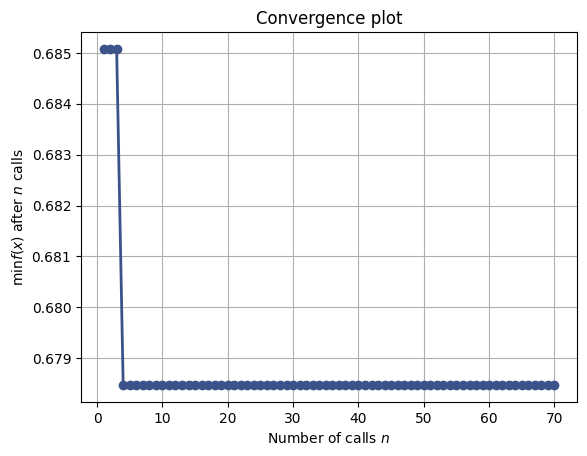

In [18]:
plot_convergence(resultados_gp)

In [19]:
resultados_gp['x']
lista_result = []
for i in resultados_gp['x']:
    lista_result.append(round(i,3))

lista_result

[349, 28, 2, 2]

In [50]:
model_RF = RandomForestRegressor(n_estimators=lista_result[0], max_depth=lista_result[1], 
                            min_samples_leaf=lista_result[2], min_samples_split=lista_result[3])

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

scores = cross_val_score(model_RF, X_treino_1, Y_treino_1, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAE: 0.707 (0.021)


In [51]:
model_RF.fit(X_treino_1, Y_treino_1)

y_pred_rf = pd.DataFrame(model_RF.predict(X_teste_1))
y_pred_rf.index = Y_teste_1.index
y_pred_rf.columns = ['predicted_mean']

f1_forest = pd.DataFrame({'Actual': Y_teste_1, 'Predicted': y_pred_rf['predicted_mean']})
 
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_teste_1, y_pred_rf['predicted_mean']))
print('Mean Squared Error:', metrics.mean_squared_error(Y_teste_1, y_pred_rf['predicted_mean']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_teste_1, y_pred_rf['predicted_mean'])))
#print('Mape:', np.mean(np.abs((Y_teste_1 - y_pred_rf['predicted_mean']) / Y_teste_1)) * 100)
print('MAPE: ', metrics.mean_absolute_percentage_error(Y_teste_1, y_pred_rf['predicted_mean']))

Mean Absolute Error: 0.6827572161718839
Mean Squared Error: 0.7812341819276993
Root Mean Squared Error: 0.8838745283849395
MAPE:  0.3419194325452397


In [52]:
fig_model = go.Figure()

# Add traces
fig_model.add_trace(
    go.Scatter(x=f1_forest.index.sort_values(), y=f1_forest['Actual'], name="Real", mode='lines')
)

fig_model.add_trace(
    go.Scatter(x=f1_forest.index.sort_values(), y=f1_forest['Predicted'], name="Predicted", mode='lines')
)

# Add figure title
fig_model.update_layout(
    title_text="XGboost - Real X Predicted"
)

# Set x-axis title
fig_model.update_xaxes(title_text="Data")
fig_model.show()

#### 2.1.3.2 XGboost

In [21]:
def treinar_modelo_XG(params):
    eta = params[0]
    n_estimators = params[1]
    max_depth = params[2]
    colsample_bytree = params[3]
    
    print(params, '\n')
    
    XG = XGBRegressor( eta= eta, n_estimators=n_estimators , max_depth=max_depth, 
                        colsample_bytree=colsample_bytree)
    
    XG.fit(X_treino_1, Y_treino_1)
    
    y_pred = XG.predict(X_teste_1)
    
    return mean_absolute_error(Y_teste_1, y_pred)

space_XG = [(0.01, 1), #eta
        (50, 300), # n_estimators
         (15, 45), # max_depth
         (0.5,1.0)] # colsample_bytree

resultados_gp = gp_minimize(treinar_modelo_XG, space_XG, random_state=12, verbose=1, n_calls=70, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[0.4517595271218509, 268, 18, 0.8618009016460738] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.7927
Function value obtained: 0.7207
Current minimum: 0.7207
Iteration No: 2 started. Evaluating function at random point.
[0.3569734932449426, 58, 24, 0.5412622055297692] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.6962
Function value obtained: 0.6761
Current minimum: 0.6761
Iteration No: 3 started. Evaluating function at random point.
[0.7286946195053848, 143, 35, 0.9918235799082561] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.5159
Function value obtained: 0.8035
Current minimum: 0.6761
Iteration No: 4 started. Evaluating function at random point.
[0.4867149086610093, 278, 21, 0.573986938417098] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.1394
Function value obtained: 0.7271
Current minimum: 0.6761
Iteration No: 5 starte

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

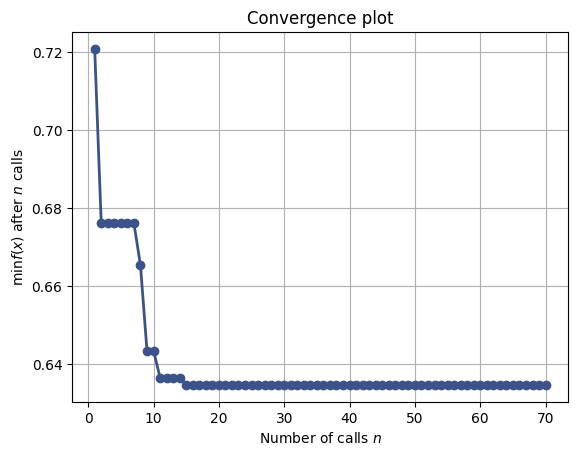

In [22]:
plot_convergence(resultados_gp)

In [23]:
resultados_gp['x']
lista_result = []
for i in resultados_gp['x']:
    lista_result.append(round(i,3))

lista_result

[0.017, 220, 29, 0.76]

In [25]:
model_XG = XGBRegressor( eta= lista_result[0], n_estimators=lista_result[1], max_depth=lista_result[2], 
                            colsample_bytree=lista_result[3])

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

scores = cross_val_score(model_XG, X_treino_1, Y_treino_1, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAE: 0.680 (0.019)


In [26]:
model_XG.fit(X_treino_1, Y_treino_1)

y_pred_xg = pd.DataFrame(model_XG.predict(X_teste_1))
y_pred_xg.index = Y_teste_1.index
y_pred_xg.columns = ['predicted_mean']

f_boost = pd.DataFrame({'Actual': Y_teste_1, 'Predicted': y_pred_xg['predicted_mean']})
 
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_teste_1, y_pred_xg['predicted_mean']))
print('Mean Squared Error:', metrics.mean_squared_error(Y_teste_1, y_pred_xg['predicted_mean']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_teste_1, y_pred_xg['predicted_mean'])))
#print('Mape:', np.mean(np.abs((Y_teste_1 - y_pred_xg['predicted_mean']) / Y_teste_1)) * 100)
print('MAPE: ', metrics.mean_absolute_percentage_error(Y_teste_1, y_pred_xg['predicted_mean']))

Mean Absolute Error: 0.6379262147475558
Mean Squared Error: 0.7360732368005591
Root Mean Squared Error: 0.8579471060622322
MAPE:  0.3037406930920576


In [28]:
fig_model = go.Figure()

# Add traces
fig_model.add_trace(
    go.Scatter(x=f_boost.index.sort_values(), y=f_boost['Actual'], name="Real", mode='lines')
)

fig_model.add_trace(
    go.Scatter(x=f_boost.index.sort_values(), y=f_boost['Predicted'], name="Predicted", mode='lines')
)

# Add figure title
fig_model.update_layout(
    title_text="XGboost - Real X Predicted"
)

# Set x-axis title
fig_model.update_xaxes(title_text="Data")
fig_model.show()

## 2.2 Data_2

### 2.2.1 Divisão do dataset(treino e teste)

In [4]:
X_2 = Data_2.drop('per_silica_concentrate', axis=1)
Y_2 = Data_2['per_silica_concentrate']

X_treino_2, X_teste_2, Y_treino_2, Y_teste_2 = train_test_split(X_2, Y_2, train_size = 0.80, random_state = 12)

print('X_treino_2: ', X_treino_2.shape)
print('X_teste_2: ', X_teste_2.shape)
print('Y_treino_2: ', Y_treino_2.shape)
print('Y_teste_2: ', Y_teste_2.shape)

X_treino_2:  (3056, 15)
X_teste_2:  (765, 15)
Y_treino_2:  (3056,)
Y_teste_2:  (765,)


In [5]:
sc_in_2 = StandardScaler()

scaled_input = sc_in_2.fit_transform(X_treino_2)

scaled_input = pd.DataFrame(scaled_input, columns=X_treino_2.columns, index= X_treino_2.index)

X_treino_2 = scaled_input

In [6]:
scaled_test = sc_in_2.transform(X_teste_2)

scaled_test = pd.DataFrame(scaled_test, columns=X_teste_2.columns, index=X_teste_2.index)

X_teste_2 = scaled_test

In [7]:
scaled_test = sc_in_2.transform(Valid_2.drop('per_silica_concentrate', axis=1))

scaled_test = pd.DataFrame(scaled_test, columns=Valid_2.drop('per_silica_concentrate', axis=1).columns, index=Valid_2.index)

X_Valid_2 = scaled_test

Y_Valid_2 = Valid_2['per_silica_concentrate']

In [16]:
X_teste_2.columns

Index(['per_silica_feed', 'per_iron_feed', 'starch_flow', 'amina_flow',
       'ore_pulp_flow', 'ore_pulp_ph', 'ore_pulp_density',
       'column_01_air_flow', 'column_03_air_flow', 'column_04_air_flow',
       'column_06_air_flow', 'column_01_level', 'column_03_level',
       'column_04_level', 'column_06_level'],
      dtype='object')

### 2.2.2 Gridsearch


In [121]:
def ML_modeling(models, params, X_train, X_test, y_train, y_test):    
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Some estimators are missing parameters')

    for key in models.keys():
         
        model = models[key]
        param = params[key]
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True)
        gs.fit(X_train, y_train, groups=None)
        y_pred = gs.predict(X_test)
        
        # Print scores for the classifier
        print(key, ':', gs.best_params_)
        print("Mape: %1.3f \tmae: %1.3f \tmse: %1.3f \n" % (mean_absolute_percentage_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)))
    return

In [122]:
models = {'Lasso Regression': Lasso(),
          'Random Forest': RandomForestRegressor(),
          'XGBoost': XGBRegressor(),
          'ADaboost': AdaBoostRegressor()
        }

params = {
          'Lasso Regression' : {'alpha': [0.01, 0.1]},
          'Random Forest': {'n_estimators': [100, 200, 500]},
          'XGBoost': {'n_estimators': [100, 200, 500]},
          'ADaboost': {'n_estimators':[100, 250,500]}
        }

In [123]:
ML_modeling(models, params, X_treino_2, X_teste_2, Y_treino_2, Y_teste_2)

Lasso Regression : {'alpha': 0.01}
Mape: 0.390 	mae: 0.798 	mse: 1.042 

Random Forest : {'n_estimators': 500}
Mape: 0.346 	mae: 0.689 	mse: 0.806 

XGBoost : {'n_estimators': 100}
Mape: 0.348 	mae: 0.696 	mse: 0.829 

ADaboost : {'n_estimators': 500}
Mape: 0.500 	mae: 0.902 	mse: 1.118 



### 2.2.3 Model tuning: Bayesian Optimization


#### 2.2.3.1 Random Forest

In [124]:
def treinar_modelo_RF(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    min_samples_split = params[3]
    
    print(params, '\n')
    
    RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    
    RF.fit(X_treino_2, Y_treino_2)
    
    y_pred = RF.predict(X_teste_2)
    
    return mean_absolute_error(Y_teste_2, y_pred)

space_RF = [(250,500, 'log-uniform'), # n_estimators
            (10, 30), # max_depth
            (1, 5), # min_samples_leaf
            (2,5) # min_samples_split
         ]


resultados_gp = gp_minimize(treinar_modelo_RF, space_RF, random_state=12, verbose=1, n_calls=70, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[341, 27, 1, 4] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.7646
Function value obtained: 0.6878
Current minimum: 0.6878
Iteration No: 2 started. Evaluating function at random point.
[319, 11, 2, 2] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 5.4865
Function value obtained: 0.6965
Current minimum: 0.6878
Iteration No: 3 started. Evaluating function at random point.
[413, 17, 4, 5] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.3508
Function value obtained: 0.6931
Current minimum: 0.6878
Iteration No: 4 started. Evaluating function at random point.
[349, 28, 2, 2] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.4542
Function value obtained: 0.6861
Current minimum: 0.6861
Iteration No: 5 started. Evaluating function at random point.
[469, 24, 5, 3] 

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 8.5587
F

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

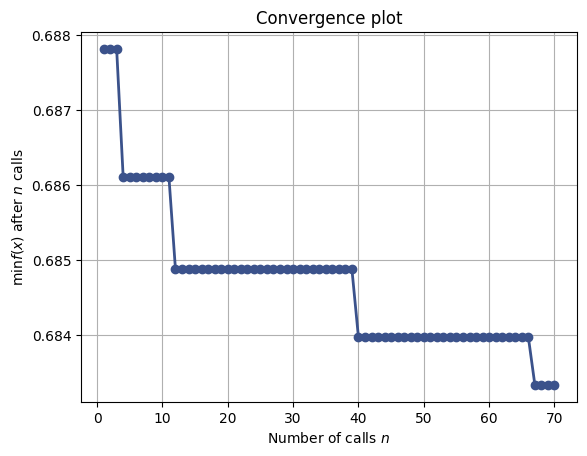

In [125]:
plot_convergence(resultados_gp)

In [126]:
resultados_gp['x']
lista_result = []
for i in resultados_gp['x']:
    lista_result.append(round(i,3))

lista_result

[255, 30, 2, 5]

In [20]:
model_RF = RandomForestRegressor(n_estimators=lista_result[0], max_depth=lista_result[1], 
                            min_samples_leaf=lista_result[2], min_samples_split=lista_result[3])

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

scores = cross_val_score(model_RF, X_treino_2, Y_treino_2, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAE: 0.719 (0.026)


In [21]:
model_RF.fit(X_treino_2, Y_treino_2)

y_pred_rf = pd.DataFrame(model_RF.predict(X_teste_2))
y_pred_rf.index = Y_teste_2.index
y_pred_rf.columns = ['predicted_mean']

f2_forest = pd.DataFrame({'Actual': Y_teste_2, 'Predicted': y_pred_rf['predicted_mean']})
 
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_teste_2, y_pred_rf['predicted_mean']))
print('Mean Squared Error:', metrics.mean_squared_error(Y_teste_2, y_pred_rf['predicted_mean']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_teste_2, y_pred_rf['predicted_mean'])))
#print('Mape:', np.mean(np.abs((Y_teste_2 - y_pred_rf['predicted_mean']) / Y_teste_2)) * 100)
print('MAPE: ', metrics.mean_absolute_percentage_error(Y_teste_2, y_pred_rf['predicted_mean']))

Mean Absolute Error: 0.7102337244970033
Mean Squared Error: 0.8636730569425154
Root Mean Squared Error: 0.9293401190858572
MAPE:  0.3495356949140265


In [22]:
fig_model = go.Figure()

# Add traces
fig_model.add_trace(
    go.Scatter(x=f2_forest.index.sort_values(), y=f2_forest['Actual'], name="Real", mode='lines')
)

fig_model.add_trace(
    go.Scatter(x=f2_forest.index.sort_values(), y=f2_forest['Predicted'], name="Predicted", mode='lines')
)

# Add figure title
fig_model.update_layout(
    title_text="XGboost - Real X Predicted"
)
# Set x-axis title
fig_model.update_xaxes(title_text="Data")
fig_model.show()

* Validação

In [23]:
y_pred_rf_valid = pd.DataFrame(model_RF.predict(X_Valid_2))
y_pred_rf_valid.index = Y_Valid_2.index
y_pred_rf_valid.columns = ['predicted_mean']

f2_valid_rf = pd.DataFrame({'Actual': Y_Valid_2, 'Predicted': y_pred_rf_valid['predicted_mean']})

In [24]:
fig_model = go.Figure()

# Add traces
fig_model.add_trace(
    go.Scatter(x=f2_valid_rf.index.sort_values(), y=f2_valid_rf['Actual'], name="Real", mode='lines')
)

fig_model.add_trace(
    go.Scatter(x=f2_valid_rf.index.sort_values(), y=f2_valid_rf['Predicted'], name="Predicted", mode='lines')
)

# Add figure title
fig_model.update_layout(
    title_text="Random Forest - Data_2 - Real X Predicted"
)
# Set x-axis title
fig_model.update_xaxes(title_text="Data")
fig_model.show()

In [25]:
mean_absolute_error(f2_valid_rf['Actual'],f2_valid_rf['Predicted'])

0.5289432794193824

#### 2.2.3.2 XGboost

In [133]:
def treinar_modelo_XG(params):
    eta = params[0]
    n_estimators = params[1]
    max_depth = params[2]
    colsample_bytree = params[3]
    
    print(params, '\n')
    
    XG = XGBRegressor( eta= eta, n_estimators=n_estimators , max_depth=max_depth, 
                        colsample_bytree=colsample_bytree)
    
    XG.fit(X_treino_2, Y_treino_2)
    
    y_pred = XG.predict(X_teste_2)
    
    return mean_absolute_error(Y_teste_2, y_pred)

space_XG = [(0.01, 1), #eta
        (100, 400), # n_estimators
         (15, 45), # max_depth
         (0.5,1.0)] # colsample_bytree

resultados_gp = gp_minimize(treinar_modelo_XG, space_XG, random_state=1, verbose=1, n_calls=100, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[0.9972129628294801, 380, 19, 0.9995202576620725] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.3030
Function value obtained: 0.8976
Current minimum: 0.8976
Iteration No: 2 started. Evaluating function at random point.
[0.24372808718245637, 219, 27, 0.8348730184017401] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.1214
Function value obtained: 0.7063
Current minimum: 0.7063
Iteration No: 3 started. Evaluating function at random point.
[0.9361836800979717, 354, 24, 0.7622740797864358] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.6229
Function value obtained: 0.8948
Current minimum: 0.7063
Iteration No: 4 started. Evaluating function at random point.
[0.4490183648417612, 169, 31, 0.9569810122896165] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.6691
Function value obtained: 0.7349
Current minimum: 0.7063
Iteration No: 5 sta

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

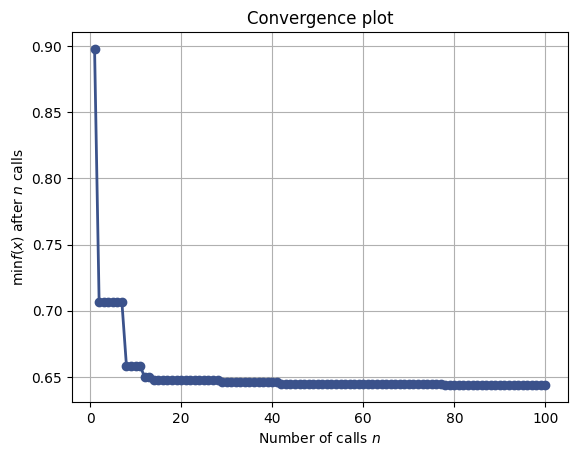

In [134]:
plot_convergence(resultados_gp)

In [135]:
resultados_gp['x']
lista_result = []
for i in resultados_gp['x']:
    lista_result.append(round(i,3))

lista_result

[0.01, 282, 15, 0.792]

In [8]:
lista_result= [0.01, 282, 15, 0.792]

In [9]:
model_XG = XGBRegressor( eta= lista_result[0], n_estimators=lista_result[1], max_depth=lista_result[2], 
                         colsample_bytree=lista_result[3])

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

scores = cross_val_score(model_XG, X_treino_2, Y_treino_2, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAE: 0.665 (0.027)


In [10]:
model_XG.fit(X_treino_2, Y_treino_2)

y_pred_xg = pd.DataFrame(model_XG.predict(X_teste_2))
y_pred_xg.index = Y_teste_2.index
y_pred_xg.columns = ['predicted_mean']

f2_boost = pd.DataFrame({'Actual': Y_teste_2, 'Predicted': y_pred_xg['predicted_mean']})
 
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_teste_2, y_pred_xg['predicted_mean']))
print('Mean Squared Error:', metrics.mean_squared_error(Y_teste_2, y_pred_xg['predicted_mean']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_teste_2, y_pred_xg['predicted_mean'])))
#print('Mape:', np.mean(np.abs((Y_teste_2 - y_pred_xg['predicted_mean']) / Y_teste_2)) * 100)
print('MAPE: ', metrics.mean_absolute_percentage_error(Y_teste_2, y_pred_xg['predicted_mean']))

Mean Absolute Error: 0.6440196132098928
Mean Squared Error: 0.7857319710070686
Root Mean Squared Error: 0.8864152362223184
MAPE:  0.2904780090510547


In [11]:
fig_model = go.Figure()

# Add traces
fig_model.add_trace(
    go.Scatter(x=f2_boost.index.sort_values(), y=f2_boost['Actual'], name="Real", mode='lines')
)

fig_model.add_trace(
    go.Scatter(x=f2_boost.index.sort_values(), y=f2_boost['Predicted'], name="Predicted", mode='lines')
)

# Add figure title
fig_model.update_layout(
    title_text="XGboost - Data_2 - Real X Predicted"
)
# Set x-axis title
fig_model.update_xaxes(title_text="Data")
fig_model.show()

* Validação

In [12]:
y_pred_xg_valid = pd.DataFrame(model_XG.predict(X_Valid_2))
y_pred_xg_valid.index = Y_Valid_2.index
y_pred_xg_valid.columns = ['predicted_mean']

f2_valid_xg = pd.DataFrame({'Actual': Y_Valid_2, 'Predicted': y_pred_xg_valid['predicted_mean']})

In [16]:
fig_model = go.Figure()

# Add traces
fig_model.add_trace(
    go.Scatter(x=X_Valid_2.index.sort_values(), y=f2_valid_xg['Actual'], name="Real", mode='lines')
)

fig_model.add_trace(
    go.Scatter(x=X_Valid_2.index.sort_values(), y=f2_valid_xg['Predicted'], name="Predicted", mode='lines')
)

# Add figure title
fig_model.update_layout(
    title_text="XGboost - Data_2 - Real X Predicted",
                  paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)', font_color="White")

# Set x and y-axis title
fig_model.update_xaxes(title_text="<b> Date </b>", showgrid=False,showline=True)
fig_model.update_yaxes(title_text="<b> % </b>", showgrid=False,showline=True)
fig_model.show()

In [15]:
mean_absolute_error(f2_valid_xg['Actual'],f2_valid_xg['Predicted'] )

0.3783435079256694

Text(0.5, 1.0, 'Importância de cada feature')

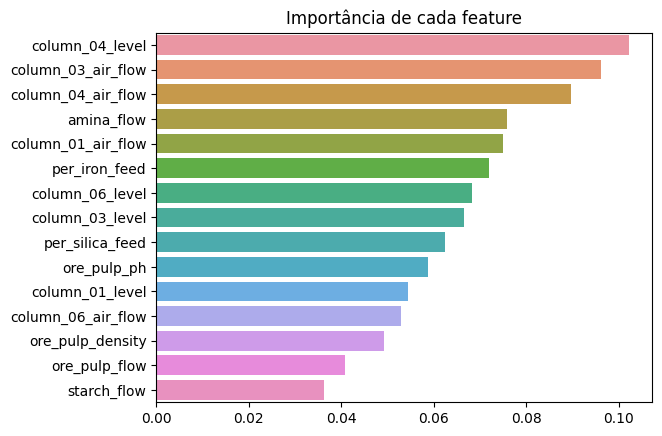

In [18]:
importances = pd.Series(data=model_XG.feature_importances_, index=X_2.columns).sort_values(ascending=False)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada feature')

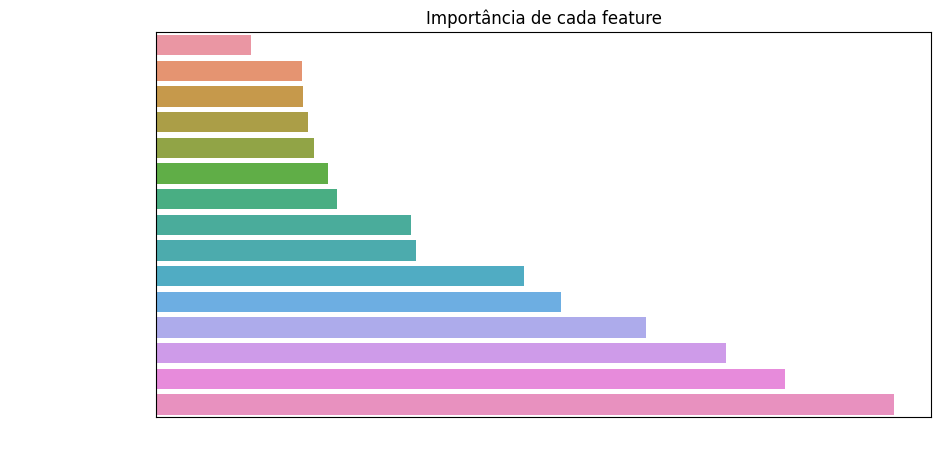

In [27]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model_XG, X_teste_2, Y_teste_2)

sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 5))

sns.barplot(x=perm_importance.importances_mean[sorted_idx], y=X_2.columns[sorted_idx], orient='h').set_title('Importância de cada feature')

plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.savefig('Decomposição.png', transparent=True)

## 2.3 Data_3

### 2.3.1 Divisão do dataset(treino e teste)

In [88]:
X_3 = Data_3.drop('per_silica_concentrate', axis=1)
Y_3 = Data_3['per_silica_concentrate']

X_treino_3, X_teste_3, Y_treino_3, Y_teste_3 = train_test_split(X_3, Y_3, train_size = 0.80, random_state = 12)

print('X_treino_3: ', X_treino_3.shape)
print('X_teste_3: ', X_teste_3.shape)
print('Y_treino_3: ', Y_treino_3.shape)
print('Y_teste_3: ', Y_teste_3.shape)

X_treino_3:  (3056, 13)
X_teste_3:  (765, 13)
Y_treino_3:  (3056,)
Y_teste_3:  (765,)


In [89]:
X_3.columns

Index(['per_iron_feed', 'per_silica_feed', 'starch_flow', 'amina_flow',
       'ore_pulp_flow', 'ore_pulp_ph', 'ore_pulp_density',
       'column_01_02_03_air_flow', 'column_04_05_air_flow',
       'column_06_07_air_flow', 'column_01_02_03_level', 'column_04_05_level',
       'column_06_07_level'],
      dtype='object')

In [90]:
sc_in_3 = StandardScaler()

scaled_input = sc_in_3.fit_transform(X_treino_3)

scaled_input = pd.DataFrame(scaled_input, columns=X_treino_3.columns, index= X_treino_3.index)

X_treino_3 = scaled_input

In [91]:
scaled_test = sc_in_3.transform(X_teste_3)

scaled_test = pd.DataFrame(scaled_test, columns=X_teste_3.columns, index=X_teste_3.index)

X_teste_3 = scaled_test

In [98]:
scaled_test = sc_in_3.transform(Valid_3.drop('per_silica_concentrate', axis=1))

scaled_test = pd.DataFrame(scaled_test, columns=Valid_3.drop('per_silica_concentrate', axis=1).columns, index=Valid_3.index)

X_Valid_3 = scaled_test

Y_Valid_3 = Valid_3['per_silica_concentrate']

### 2.3.2 Gridsearch


In [92]:
def ML_modeling(models, params, X_train, X_test, y_train, y_test):    
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Some estimators are missing parameters')

    for key in models.keys():
         
        model = models[key]
        param = params[key]
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True)
        gs.fit(X_train, y_train, groups=None)
        y_pred = gs.predict(X_test)
        
        # Print scores for the classifier
        print(key, ':', gs.best_params_)
        print("Mape: %1.3f \tmae: %1.3f \tmse: %1.3f \n" % (mean_absolute_percentage_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)))
    return

In [93]:
models = {'Lasso Regression': Lasso(),
          'Random Forest': RandomForestRegressor(),
          'XGBoost': XGBRegressor(),
          'ADaboost': AdaBoostRegressor()
        }

params = {
          'Lasso Regression' : {'alpha': [0.01, 0.1]},
          'Random Forest': {'n_estimators': [100, 200, 500]},
          'XGBoost': {'n_estimators': [100, 200, 500]},
          'ADaboost': {'n_estimators':[100, 250,500]}
        }

In [94]:
ML_modeling(models, params, X_treino_3, X_teste_3, Y_treino_3, Y_teste_3)

Lasso Regression : {'alpha': 0.01}
Mape: 0.394 	mae: 0.804 	mse: 1.054 

Random Forest : {'n_estimators': 200}
Mape: 0.352 	mae: 0.708 	mse: 0.848 

XGBoost : {'n_estimators': 100}
Mape: 0.345 	mae: 0.699 	mse: 0.855 

ADaboost : {'n_estimators': 100}
Mape: 0.505 	mae: 0.914 	mse: 1.136 



### 2.3.3 Model tuning: Bayesian Optimization

#### 2.3.3.1 Random Forest

In [99]:
def treinar_modelo_RF(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    min_samples_split = params[3]
    
    print(params, '\n')
    
    RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    
    RF.fit(X_treino_3, Y_treino_3)
    
    y_pred = RF.predict(X_teste_3)
    
    return mean_absolute_error(Y_teste_3, y_pred)

space_RF = [(250,500, 'log-uniform'), # n_estimators
            (10, 30), # max_depth
            (1, 5), # min_samples_leaf
            (2,5) # min_samples_split
         ]


resultados_gp = gp_minimize(treinar_modelo_RF, space_RF, random_state=12, verbose=1, n_calls=70, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[341, 27, 1, 4] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.1608
Function value obtained: 0.7012
Current minimum: 0.7012
Iteration No: 2 started. Evaluating function at random point.
[319, 11, 2, 2] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.9139
Function value obtained: 0.7066
Current minimum: 0.7012
Iteration No: 3 started. Evaluating function at random point.
[413, 17, 4, 5] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.9818
Function value obtained: 0.7060
Current minimum: 0.7012
Iteration No: 4 started. Evaluating function at random point.
[349, 28, 2, 2] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.7959
Function value obtained: 0.7023
Current minimum: 0.7012
Iteration No: 5 started. Evaluating function at random point.
[469, 24, 5, 3] 

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 7.4132
F

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

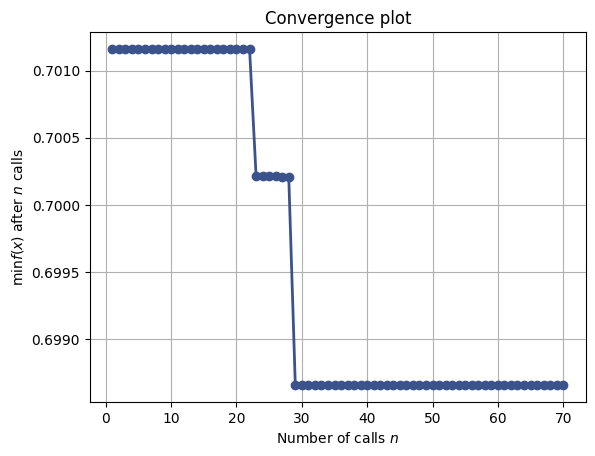

In [100]:
plot_convergence(resultados_gp)

In [101]:
resultados_gp['x']
lista_result = []
for i in resultados_gp['x']:
    lista_result.append(round(i,3))

lista_result

[253, 30, 1, 5]

In [102]:
model_RF = RandomForestRegressor(n_estimators=lista_result[0], max_depth=lista_result[1], 
                            min_samples_leaf=lista_result[2], min_samples_split=lista_result[3])

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

scores = cross_val_score(model_RF, X_treino_3, Y_treino_3, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAE: 0.698 (0.024)


In [103]:
model_RF.fit(X_treino_3, Y_treino_3)

y_pred_rf = pd.DataFrame(model_RF.predict(X_teste_3))
y_pred_rf.index = Y_teste_3.index
y_pred_rf.columns = ['predicted_mean']

f3_forest = pd.DataFrame({'Actual': Y_teste_3, 'Predicted': y_pred_rf['predicted_mean']})
 
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_teste_3, y_pred_rf['predicted_mean']))
print('Mean Squared Error:', metrics.mean_squared_error(Y_teste_3, y_pred_rf['predicted_mean']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_teste_3, y_pred_rf['predicted_mean'])))
#print('Mape:', np.mean(np.abs((Y_teste_3 - y_pred_rf['predicted_mean']) / Y_teste_3)) * 100)
print('MAPE: ', metrics.mean_absolute_percentage_error(Y_teste_3, y_pred_rf['predicted_mean']))

Mean Absolute Error: 0.7023182646339066
Mean Squared Error: 0.8426362261506317
Root Mean Squared Error: 0.9179521916475998
MAPE:  0.3499641294880869


In [104]:
fig_model = go.Figure()

# Add traces
fig_model.add_trace(
    go.Scatter(x=f3_forest.index.sort_values(), y=f3_forest['Actual'], name="Real", mode='lines')
)

fig_model.add_trace(
    go.Scatter(x=f3_forest.index.sort_values(), y=f3_forest['Predicted'], name="Predicted", mode='lines')
)

# Add figure title
fig_model.update_layout(
    title_text="Random Forest - Data_3 - Real X Predicted"
)
# Set x-axis title
fig_model.update_xaxes(title_text="Data")
fig_model.show()

* Validação

In [105]:
y_pred_rf_valid = pd.DataFrame(model_RF.predict(X_Valid_3))
y_pred_rf_valid.index = Y_Valid_3.index
y_pred_rf_valid.columns = ['predicted_mean']

f3_valid_rf = pd.DataFrame({'Actual': Y_Valid_3, 'Predicted': y_pred_rf_valid['predicted_mean']})

In [106]:
fig_model = go.Figure()

# Add traces
fig_model.add_trace(
    go.Scatter(x=f3_valid_rf.index.sort_values(), y=f3_valid_rf['Actual'], name="Real", mode='lines')
)

fig_model.add_trace(
    go.Scatter(x=f3_valid_rf.index.sort_values(), y=f3_valid_rf['Predicted'], name="Predicted", mode='lines')
)

# Add figure title
fig_model.update_layout(
    title_text="XGboost - Real X Predicted"
)
# Set x-axis title
fig_model.update_xaxes(title_text="Data")
fig_model.show()

In [116]:
mean_absolute_error(f3_valid_rf['Actual'], f3_valid_rf['Predicted'])

0.5118030122591141

#### 2.3.3.2 XGboost

In [107]:
def treinar_modelo_XG(params):
    eta = params[0]
    n_estimators = params[1]
    max_depth = params[2]
    colsample_bytree = params[3]
    
    print(params, '\n')
    
    XG = XGBRegressor( eta= eta, n_estimators=n_estimators , max_depth=max_depth, 
                        colsample_bytree=colsample_bytree)
    
    XG.fit(X_treino_3, Y_treino_3)
    
    y_pred = XG.predict(X_teste_3)
    
    return mean_absolute_error(Y_teste_3, y_pred)

space_XG = [(0.01, 1), #eta
        (50, 300), # n_estimators
         (15, 45), # max_depth
         (0.5,1.0)] # colsample_bytree

resultados_gp = gp_minimize(treinar_modelo_XG, space_XG, random_state=1, verbose=1, n_calls=70, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[0.9972129628294801, 283, 19, 0.9995202576620725] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.5782
Function value obtained: 0.9132
Current minimum: 0.9132
Iteration No: 2 started. Evaluating function at random point.
[0.24372808718245637, 149, 27, 0.8348730184017401] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.0861
Function value obtained: 0.7089
Current minimum: 0.7089
Iteration No: 3 started. Evaluating function at random point.
[0.9361836800979717, 262, 24, 0.7622740797864358] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.0396
Function value obtained: 0.8701
Current minimum: 0.7089
Iteration No: 4 started. Evaluating function at random point.
[0.4490183648417612, 107, 31, 0.9569810122896165] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 24.9443
Function value obtained: 0.7491
Current minimum: 0.7089
Iteration No: 5 st

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

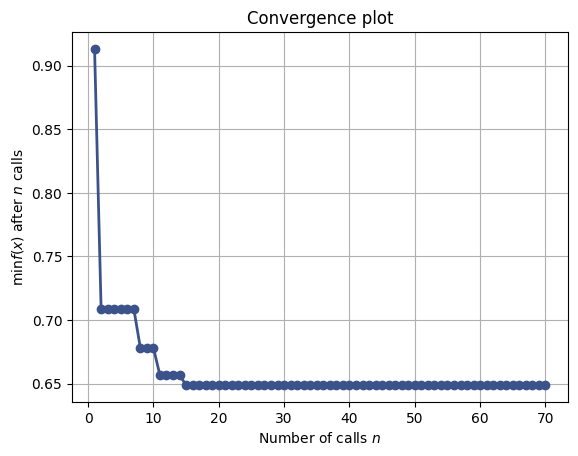

In [108]:
plot_convergence(resultados_gp)

In [109]:
resultados_gp['x']
lista_result = []
for i in resultados_gp['x']:
    lista_result.append(round(i,3))

lista_result

[0.01, 300, 15, 0.54]

In [110]:
model_XG = XGBRegressor( eta= lista_result[0], n_estimators=lista_result[1], max_depth=lista_result[2], 
                         colsample_bytree=lista_result[3])

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

scores = cross_val_score(model_XG, X_treino_3, Y_treino_3, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAE: 0.666 (0.028)


In [111]:
model_XG.fit(X_treino_3, Y_treino_3)

y_pred_xg = pd.DataFrame(model_XG.predict(X_teste_3))
y_pred_xg.index = Y_teste_3.index
y_pred_xg.columns = ['predicted_mean']

f3_boost = pd.DataFrame({'Actual': Y_teste_3, 'Predicted': y_pred_xg['predicted_mean']})
 
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_teste_3, y_pred_xg['predicted_mean']))
print('Mean Squared Error:', metrics.mean_squared_error(Y_teste_3, y_pred_xg['predicted_mean']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_teste_3, y_pred_xg['predicted_mean'])))
#print('Mape:', np.mean(np.abs((Y_teste_3 - y_pred_xg['predicted_mean']) / Y_teste_3)) * 100)
print('MAPE: ', metrics.mean_absolute_percentage_error(Y_teste_3, y_pred_xg['predicted_mean']))

Mean Absolute Error: 0.6489438280155456
Mean Squared Error: 0.7932844025736385
Root Mean Squared Error: 0.8906651461540631
MAPE:  0.2981170639505125


In [112]:
fig_model = go.Figure()

# Add traces
fig_model.add_trace(
    go.Scatter(x=f3_boost.index.sort_values(), y=f3_boost['Actual'], name="Real", mode='lines')
)

fig_model.add_trace(
    go.Scatter(x=f3_boost.index.sort_values(), y=f3_boost['Predicted'], name="Predicted", mode='lines')
)

# Add figure title
fig_model.update_layout(
    title_text="XGboost - Real X Predicted"
)
# Set x-axis title
fig_model.update_xaxes(title_text="Data")
fig_model.show()

* Validação

In [113]:
y_pred_xg_valid = pd.DataFrame(model_XG.predict(X_Valid_3))
y_pred_xg_valid.index = Y_Valid_3.index
y_pred_xg_valid.columns = ['predicted_mean']

f3_valid_xg = pd.DataFrame({'Actual': Y_Valid_3, 'Predicted': y_pred_xg_valid['predicted_mean']})

In [114]:
fig_model = go.Figure()

# Add traces
fig_model.add_trace(
    go.Scatter(x=f3_valid_xg.index.sort_values(), y=f3_valid_xg['Actual'], name="Real", mode='lines')
)

fig_model.add_trace(
    go.Scatter(x=f3_valid_xg.index.sort_values(), y=f3_valid_xg['Predicted'], name="Predicted", mode='lines')
)

# Add figure title
fig_model.update_layout(
    title_text="XGboost - Data_3 - Real X Predicted"
)
# Set x-axis title
fig_model.update_xaxes(title_text="Data")
fig_model.show()

In [115]:
mean_absolute_error(f3_valid_xg['Actual'], f3_valid_xg['Predicted'])

0.34547166236241655

# 3. Resultado final

## 3.2 Conclusão



> Resultados:

* Data_1:
    - Random Forest: mae: 0.68 | MSE: 0.78 | RMSE: 0.88 | MAPE: 0.34
    - XGBoost: mae: 0.63 | MSE: 0.73 | RMSE: 0.85 | MAPE: 0.30

* Data_2:
    - Random Forest: mae: 0.68 | MSE: 0.78 | RMSE: 0.9 | MAPE: 0.34
    - XGBoost: mae: 0.627 | MSE: 0.74 | RMSE: 0.86 | MAPE: 0.28

* Data_3:
    - Randon Forest: mae: 0.70 | MSE: 0.84 | RMSE: 0.91 | MAPE: 0.35
    - XGBoost: mae: 0.65 | MSE: 0.79 | RMSE: 0.89 | MAPE: 0.30

    - 

* Não houve diferença entre os resultados obtidos pelos modelos utilizando o Data_1 ou Data_2.
* O Data_2 seria o escolhido, pois reproduziu os melhores resultados utilizando um dataset com menor número de variáveis.

* O XGboost se mostrou a melhor opção, mesmo não tendo muita diferenças.


> Próximo Passo:

* Iremos testar outro approach, agora avaliando os modelos de série temporal e analisando se essa seria uma boa alternativa.

<img src="./imagens/XGBoost_result.png"/>

# 4. Referências

* XGBoost:

        - https://xgboost.readthedocs.io/en/stable/

* Scikit-learn:

        - https://scikit-learn.org/stable/user_guide.html